In [1]:
import os
os.environ["tf_cpp_min_log_level"] = "2"

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, confusion_matrix
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SVMSMOTE, SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from tqdm import tqdm

from xgboost import XGBClassifier

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Input, Model, optimizers, losses, layers, activations, Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, TimeDistributed, Dropout, BatchNormalization
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format="svg"

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices[0]

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

In [5]:
#Load the datasets without and with missing values handled by two methods
path = "D:/Datasets/Diabetes/Diabetes_withMissingValues.csv"
path1 = "D:/Datasets/Diabetes/Diabetes_FillMissing_by_MEAN.csv"
path2 = "D:/Datasets/Diabetes/Diabetes_FillMissing_by_RF1.csv"

df = pd.read_csv(path)
df = df.iloc[:, 1:].drop(['weight', 'medical_specialty'], axis=1)

df_mode = pd.read_csv(path1)
df_mode = df_mode.iloc[:,1:]

df_rf = pd.read_csv(path2)
df_rf = df_rf.iloc[:,1:]

#Check the shape and feature uniformity of the datasets
df.shape, df_mode.shape, df_rf.shape, df.columns==df_mode.columns, df.columns==df_rf.columns

((101766, 42),
 (101766, 42),
 (101766, 42),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True]))

### Define Evaluation Metrics

In [6]:
#Define the evaluation metrics
def Evaluation_Metrics(y_test, y_pred):
    #auc score
    auc = roc_auc_score(y_test, y_pred)
    #recall
    recall = recall_score(y_test, y_pred)
    #accuracy
    acc = accuracy_score(y_test, y_pred)
    #specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity=tn/(tn+fp)
    
    return auc, recall, acc, specificity

## Compare the mean and RF missing value handling methods

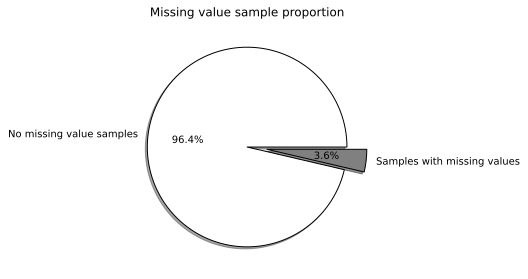

In [7]:
#Check the rows without missing values in the original dataset
df_no_missing = df.dropna()

#Visualise the missing value proportion
plt.pie([df_no_missing.shape[0], (df.shape[0]-df_no_missing.shape[0])],\
        colors=["white", "grey"],
       wedgeprops={"edgecolor":"black"},
       explode=[0, 0.2],
       labels=["No missing value samples", "Samples with missing values"],
       shadow=True,
       autopct="%1.1f%%")
plt.title("Missing value sample proportion")
plt.tight_layout()
plt.show()

# Data Preprocessing

In [8]:
#Split and scale the dataset
def Split_And_Scale(df):
    x = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    
    #Standardise the predictors
    scaler = MinMaxScaler()
    x_scaled = scaler.fit_transform(x)
    
    #Split the dataset into training and testing sets in stratified style
    x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, random_state=42, stratify=y)   
    
    #SMOTE the minority class, undersample the majority class in the training set
    smote=SMOTE(n_jobs=-1)
#     enn = EditedNearestNeighbours(n_jobs=-1)
#     smoteenn = SMOTEENN(smote=smote, enn=enn, random_state=100) 

    x_train, y_train = smote.fit_resample(x_train, y_train)
    
    return x_train, y_train, x_test, y_test

### Determine how many features to select
#### Chi-Square test

In [9]:
x = df_rf.iloc[:,:-1]
y = df_rf.iloc[:,-1]
#Normalisation
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

#For Chi-square test
chi_val, p_val = chi2(x_scaled, y)
chi_valus = np.sort(chi_val)[::-1]
chi_valus

array([3.31645869e+02, 9.89181555e+01, 4.34967763e+01, 4.01275109e+01,
       2.16236223e+01, 2.08333359e+01, 2.03595688e+01, 1.72186810e+01,
       1.48392300e+01, 9.68644310e+00, 8.26205687e+00, 5.50712221e+00,
       4.02652016e+00, 3.76063379e+00, 3.59391671e+00, 3.07279164e+00,
       2.96210580e+00, 2.30234179e+00, 2.05246734e+00, 1.88576299e+00,
       1.76225783e+00, 1.54797348e+00, 1.24234644e+00, 1.12473819e+00,
       1.07651152e+00, 1.04837346e+00, 4.98882756e-01, 4.21048735e-01,
       3.76854074e-01, 2.70210563e-01, 2.51236050e-01, 2.36397773e-01,
       1.79415289e-01, 1.57664352e-01, 1.25618025e-01, 1.25618025e-01,
       8.13506174e-02, 4.07586959e-02, 2.32592560e-02, 1.83358261e-02,
       2.75536079e-03])

In [10]:
df_rf[df_rf<0].sum()

race                        0.0
gender                      0.0
age                         0.0
admission_type_id           0.0
discharge_disposition_id    0.0
admission_source_id         0.0
time_in_hospital            0.0
num_lab_procedures          0.0
num_procedures              0.0
num_medications             0.0
number_outpatient           0.0
number_emergency            0.0
number_inpatient            0.0
diag_1                      0.0
diag_2                      0.0
diag_3                      0.0
number_diagnoses            0.0
max_glu_serum               0.0
A1Cresult                   0.0
metformin                   0.0
repaglinide                 0.0
nateglinide                 0.0
chlorpropamide              0.0
glimepiride                 0.0
glipizide                   0.0
glyburide                   0.0
tolbutamide                 0.0
pioglitazone                0.0
rosiglitazone               0.0
acarbose                    0.0
miglitol                    0.0
troglita

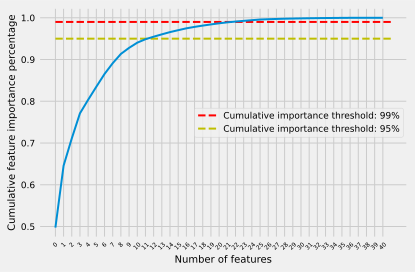

In [11]:
#Plot the cumsum feature importance in terms of chi-values
plt.style.use("fivethirtyeight")

chi_cumvalues = np.cumsum(chi_valus)/np.sum(chi_valus)
n_features = np.arange(len(chi_valus))
threshold1 = 0.99
threshold2 = 0.95

plt.plot(n_features, chi_cumvalues, lw=2)
plt.hlines(threshold1, xmin=0, xmax=41, linestyle="--", lw=2,
           color="r", label="Cumulative importance threshold: 99%")
plt.hlines(threshold2, xmin=0, xmax=41, linestyle="--", lw=2,
           color="y", label="Cumulative importance threshold: 95%")

plt.xticks(n_features, fontsize=6, rotation=45)
plt.yticks(fontsize=9)

plt.xlabel("Number of features", fontsize=10)
plt.ylabel("Cumulative feature importance percentage", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.legend(loc="center right", fontsize=9)

In [12]:
#Split and scale the dataset with feature selection
def Split_And_Scale_With_FS(df):
    x = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    
    #Standardise the predictors
    scaler = MinMaxScaler()
    x_scaled = scaler.fit_transform(x)
    
    #Feature selection
#     x_fs = SelectKBest(score_function=chi2, k=12).fit_transform(x_scaled, y)
#     x_fs = PCA(n_components=0.99, svd_solver="full").fit_transform(x_scaled, y)
    x_fs = x_scaled[:, indices_rf]

    #Split the dataset into training and testing sets in stratified style
    x_train, x_test, y_train, y_test = train_test_split(x_fs, y, test_size=0.3, random_state=42, stratify=y)
    
    #SMOTE the minority class, undersample the majority class in the training set
    smote=SMOTE(n_jobs=-1)

    x_train, y_train = smote.fit_resample(x_train, y_train)
    
    return x_train, y_train, x_test, y_test

### Prepare the datasets with missing values filled by Mean and Mode, and by RF

#### Not use Feature Selection method

In [46]:
#Get the training and testing sets of dataset with mean and mode
x_train1, y_train1, x_test1, y_test1 = Split_And_Scale(df_mode)
y_train1.value_counts(), y_test1.value_counts()

(1    63286
 0    63286
 Name: readmitted, dtype: int64,
 0    27123
 1     3407
 Name: readmitted, dtype: int64)

In [49]:
#Get the training and testing sets of dataset with RF
x_train2, y_train2, x_test2, y_test2 = Split_And_Scale(df_rf)
y_train2.value_counts(), y_test2.value_counts()

(1.0    63286
 0.0    63286
 Name: readmitted, dtype: int64,
 0.0    27123
 1.0     3407
 Name: readmitted, dtype: int64)

#### Use the FS method

In [48]:
#Get the training and testing sets of dataset with RF
x_train2, y_train2, x_test2, y_test2 = Split_And_Scale_With_FS(df_rf)
y_train2.value_counts(), y_test2.value_counts()

(1.0    63286
 0.0    63286
 Name: readmitted, dtype: int64,
 0.0    27123
 1.0     3407
 Name: readmitted, dtype: int64)

In [ ]:
x_train2.shape

### GBM model

In [ ]:
#1. GBM Tuning
def GBM_Tuning(x_train, y_train, x_valid, y_valid):
    n_estimators = [5000,6000]
    max_depth=[6, 8]
    learning_rate=[0.4, 0.5]
    subsample=[0.1]

    estimators=[]
    depths=[]
    lrs=[]
    subsamples=[]
    accuracy=[]

    for n_estimator in tqdm(n_estimators):
        for depth in max_depth:
            for lr in learning_rate:
                for ss in tqdm(subsample):
                    gbm = XGBClassifier(n_estimators=n_estimator, max_depth=depth, learning_rate=lr, subsample=ss,\
                                        eval_metric = "logloss", tree_method="gpu_hist", gpu_id=0, n_jobs =-1, use_label_encoder=False)

                    estimators.append(n_estimator)
                    depths.append(depth)
                    lrs.append(lr)
                    subsamples.append(ss)

                    gbm.fit(x_train, y_train)

                    predictions = gbm.predict(x_valid)
                    recall = recall_score(y_valid, predictions)
                    accuracy.append(recall)

    df_mode_gbm_tuning = pd.DataFrame({
        "n_estimators":estimators,
        "max_depth":depths,
        "learning_rate":lrs,
        "subsample":subsamples,
        "recall":accuracy
    })

    return df_mode_gbm_tuning.sort_values(by=["recall"], ascending=False)
    

GBM_Tuning(x_train1, y_train1, x_test1, y_test1)

In [50]:
#GBM
# gbm1=XGBClassifier(n_estimators=1000, max_depth=8, learning_rate=0.3, subsample=0.1,\
#                                         eval_metric = "logloss", tree_method="gpu_hist", gpu_id=0, n_jobs =-1, use_label_encoder=False)
gbm2=XGBClassifier(n_estimators=2500, max_depth=6, learning_rate=0.3, subsample=0.1,\
                                        eval_metric = "logloss", tree_method="gpu_hist", gpu_id=0, n_jobs =-1, use_label_encoder=False)

# #Mode dataset
# gbm1.fit(x_train1, y_train1)
# auc1_gbm, recall1_gbm, acc1_gbm, specificity1_gbm = Evaluation_Metrics(y_test1, gbm1.predict(x_test1))

#RF dataset
gbm2.fit(x_train2, y_train2)
auc2_gbm, recall2_gbm, acc2_gbm, specificity2_gbm = Evaluation_Metrics(y_test2, gbm2.predict(x_test2))

# auc1_gbm, auc2_gbm, recall1_gbm, recall2_gbm, acc1_gbm, acc2_gbm, specificity1_gbm, specificity2_gbm
auc2_gbm, recall2_gbm, acc2_gbm, specificity2_gbm

(0.5324869926661485,
 0.18579395362488993,
 0.8018015067147068,
 0.879180031707407)

In [54]:
gbm2.feature_importances_[indices_gbm]

array([0.03979011, 0.03783799, 0.03728404, 0.0358339 , 0.0354159 ,
       0.03520811, 0.03420087, 0.03411679, 0.03400649, 0.03387935,
       0.03377694, 0.03367362, 0.03363595, 0.03361772, 0.03338593,
       0.03286909, 0.0325388 , 0.0324819 , 0.03136105, 0.03129045,
       0.03077506, 0.03069103, 0.03028588, 0.02979598, 0.02931082,
       0.02914672, 0.0285884 ], dtype=float32)

In [55]:
df_rf.columns[indices_gbm]

Index(['number_inpatient', 'glyburide-metformin', 'glimepiride',
       'number_emergency', 'number_outpatient', 'pioglitazone', 'diag_2',
       'diag_3', 'diag_1', 'num_lab_procedures', 'max_glu_serum', 'A1Cresult',
       'repaglinide', 'glyburide', 'rosiglitazone', 'num_medications',
       'discharge_disposition_id', 'glipizide', 'race', 'time_in_hospital',
       'number_diagnoses', 'metformin', 'admission_source_id',
       'num_procedures', 'admission_type_id', 'diabetesMed', 'nateglinide'],
      dtype='object')

### MLP model

In [ ]:
#2. MLP Tuning
io_mlp = Input(shape=(x_train2.shape[1]))
x = Dense(25)(io_mlp)
x = BatchNormalization()(x)
x = layers.LeakyReLU(0.3)(x)
# x = Dropout(0.3)(x)

x = Dense(20, kernel_regularizer=keras.regularizers.l2(5e-3))(x)
x = BatchNormalization()(x)
x = layers.LeakyReLU(0.3)(x)
x = Dropout(0.2)(x)

x = Dense(15, kernel_regularizer=keras.regularizers.l2(5e-3))(x)
x = BatchNormalization()(x)
x = layers.LeakyReLU(0.3)(x)

x = Dense(10, kernel_regularizer=keras.regularizers.l2(5e-3))(x)
x = BatchNormalization()(x)
x = layers.LeakyReLU(0.3)(x)

x = Dense(5, kernel_regularizer=keras.regularizers.l2(5e-3))(x)
x = BatchNormalization()(x)
x = layers.LeakyReLU(0.3)(x)

output = Dense(2, activation="softmax")(x)

mlp = Model(inputs=io_mlp, outputs=output)

### Tensorboard

In [ ]:
#Tensorboard for recall
#Callback for metrics
class Metrics(keras.callbacks.Callback):
    def __init__(self, model, x_valid, y_valid, path):
        super().__init__()
        self.model=model
        self.x_valid=x_valid
        self.y_valid=y_valid

        self.recall_wr=tf.summary.create_file_writer(path+"recall/")
        self.auc_wr=tf.summary.create_file_writer(path+"auc/")
    
    def on_epoch_end(self, epoch, log=None):
        predictions=self.model.predict(self.x_valid)
        predictions=tf.argmax(predictions, axis=1)
        
        auc, recall, acc, specificity = Evaluation_Metrics(self.y_valid, predictions)
        print("AUC: {}, Recall: {},\nAcc: {}, Specificity: {}".format(auc, recall, acc, specificity))
        
        with self.recall_wr.as_default():
            tf.summary.scalar("Recall", float(recall), step=epoch)
        with self.auc_wr.as_default():
            tf.summary.scalar("AUC", float(auc), step=epoch)
        
#         if recall>0.70:
#             self.model.stop_training = True

#Callback for tensorboard
tb_callback=keras.callbacks.TensorBoard(log_dir="D:/Python/Tensorflow/Logs/Readmission/MLP/", histogram_freq=1)
tb_callback2=keras.callbacks.TensorBoard(log_dir="D:/Python/Tensorflow/Logs/Readmission/LSTM/", histogram_freq=1)

In [ ]:
optimiser=optimizers.Adam(1e-4)
# optimiser=optimizers.SGD(1e-5, momentum=0.3, nesterov=True)
loss_fn = losses.BinaryCrossentropy()

mlp.compile(optimizer=optimiser, metrics=["acc"], loss=loss_fn)

#onehot
y_train2_onehot = tf.one_hot(y_train2, depth=2)

metric = Metrics(model=mlp, x_valid=x_test2, y_valid=y_test2, path="D:/Python/Tensorflow/Logs/Readmission/MLP/")
mlp.fit(x_train2, y_train2_onehot, epochs=1000, initial_epoch=0, batch_size=128, \
        callbacks=[metric, tb_callback],\
        workers=8, use_multiprocessing=True)

# pred2 = mlp.predict(x_test2)
# pred2 = tf.argmax(pred2, axis=1)

# auc1, recall1, acc1, specificity1 = Evaluation_Metrics(y_test2, pred2)


### LSTM model

#### Group the events by the patients

In [2]:
#read the original dataset
df_original=pd.read_csv("D:/Datasets/Diabetes/diabetic_data.csv")

In [13]:
#Add the patient id and encounter id to the dataset
df_lstm1 = df_mode.copy()
df_lstm2 = df_rf.copy()

df_lstm1["patient_nbr"]=df_original["patient_nbr"]
df_lstm1["encounter_id"]=df_original["encounter_id"]

df_lstm2["patient_nbr"]=df_original["patient_nbr"]
df_lstm2["encounter_id"]=df_original["encounter_id"]

In [14]:
df_lstm2.readmitted.value_counts()

0.0    90409
1.0    11357
Name: readmitted, dtype: int64

ValueError: too many values to unpack (expected 2)

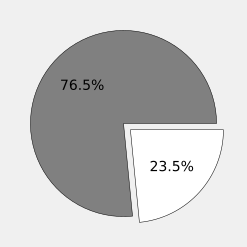

In [28]:
#Get the unique patients
patients1, counts1 = np.unique(df_lstm1["patient_nbr"], return_counts=True)
patients2, counts2 = np.unique(df_lstm2["patient_nbr"], return_counts=True)

#Visualise the n_patients distribution
count_id, count_values = np.unique(counts2, return_counts=True)

import matplotlib.cm as cm

colors =  ["grey","white"]
wedges, _  = plt.pie([count_values[0],sum(count_values[1:])], colors=colors, wedgeprops={"edgecolor":"black"}, autopct="%1.1f%%",\
                    explode=[0,0.1])
plt.tight_layout()
plt.legend(wedges, count_id, loc="lower right", fontsize=11)

#Config the legend color
ax = plt.gca()
leg = ax.get_legend()


In [29]:
scaler = MinMaxScaler((-1,1))
max(df_lstm2.num_lab_procedures), min(df_lstm2.num_lab_procedures)

(132.0, 1.0)

#### Retrieve the encounters of each patients from 1 to N

In [30]:
#Get the indices of the top 12 important features
def Index_Top_K_Features(arr_feature_importance, k):
    indices=[]

    standard=arr_feature_importance.copy()
    for _ in range(k):
        for idx in range(arr_feature_importance.shape[0]):
            if arr_feature_importance[idx] == np.max(standard):
                indices.append(idx)
                standard=np.delete(arr=standard, obj=np.argmax(standard))
                break
    
    return indices

In [31]:
#Get the encounters by patient to add time step
def Group_Patients_Time_Step(df, indices_features):
    '''df: the dataframe you want to apply grouping
       indices_features: the index of the features you want to select'''
    
    patient_groups = []
    patient_groups1 = []
    patient_groups2 = []
    patient_groups3 = []
    
    target_groups=[]
    for patient in tqdm(patients2):
        grp_patient = df.groupby("patient_nbr").get_group(patient)
        #drop the patient and event ids
        encounters = grp_patient.iloc[:, :-2].to_numpy()
        
        #The index of the feaure columns that need to be selected
            #No FS
        predictors = encounters[:,:-1]
            
            #1st, 2nd, 3rd FS method
        predictors1 = predictors[:, indices_features[0]]
        predictors2 = predictors[:, indices_features[1]]
        predictors3 = predictors[:, indices_features[2]]

        #Get the sub-encounter groups by encounters
            #n_encounter is actually the row_id plus one of the encounters
        for n_encounter in tqdm(range(1, len(encounters)+1)):
            #For each number of encounters needed to be grouped
            subgroup=[]
            subgroup1=[]
            subgroup2=[]
            subgroup3=[]
            
            for i in range(n_encounter):
                #Predictors per row
                predictor_row = predictors[i]
                subgroup.append(predictor_row)
                
                predictor_row1 = predictors1[i]
                subgroup1.append(predictor_row1)
                predictor_row2 = predictors2[i]
                subgroup2.append(predictor_row2)
                predictor_row3 = predictors3[i]
                subgroup3.append(predictor_row3)
#                 print(predictor_row3)

            #Target
            target = encounters[n_encounter-1][-1]

            patient_groups.append(subgroup)
            patient_groups1.append(subgroup1)
            patient_groups2.append(subgroup2)
            patient_groups3.append(subgroup3)
            
            target_groups.append(target)
            
    return patient_groups, patient_groups1, patient_groups2, patient_groups3, target_groups


### Prepare the datasets

### PCA

In [32]:
x = df_lstm2.iloc[:, :-3]
y = df_lstm2.iloc[:,-3]

#Normalisation
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

pca = PCA(n_components=41)
pca.fit(x_scaled)
pca.explained_variance_ratio_

array([3.14683029e-01, 8.93570687e-02, 7.43543454e-02, 6.39269439e-02,
       5.76353422e-02, 5.14490869e-02, 4.52076778e-02, 4.30744179e-02,
       2.86533473e-02, 2.78710271e-02, 2.39849137e-02, 2.08330433e-02,
       1.78564600e-02, 1.68466723e-02, 1.52805165e-02, 1.48179122e-02,
       1.43581234e-02, 1.33092832e-02, 1.14873377e-02, 1.03771458e-02,
       9.96133504e-03, 7.37403713e-03, 6.31487383e-03, 5.48506824e-03,
       4.88419604e-03, 4.59223273e-03, 2.78765781e-03, 8.07308386e-04,
       7.14074166e-04, 6.80963438e-04, 3.17490659e-04, 1.82795589e-04,
       1.20685630e-04, 1.10326618e-04, 1.03266079e-04, 8.33834649e-05,
       6.09289252e-05, 2.38626950e-05, 1.59112391e-05, 7.95509449e-06,
       7.95253368e-06])

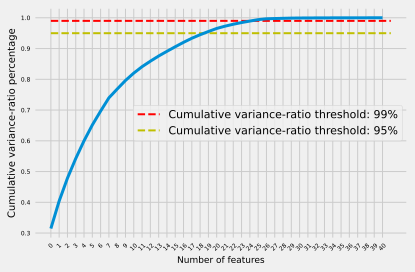

In [33]:
#Plot the cumsum feature importance in terms of pca
pca_valus = np.sort(pca.explained_variance_ratio_)[::-1]

plt.style.use("fivethirtyeight")

pca_cumvalues = np.cumsum(pca_valus)/np.sum(pca_valus)
n_features = np.arange(len(pca_valus))
threshold1 = 0.99
threshold2 = 0.95

plt.plot(n_features, pca_cumvalues, lw=3)
plt.hlines(threshold1, xmin=0, xmax=41, linestyle="--", lw=2,
           color="r", label="Cumulative variance-ratio threshold: 99%")
plt.hlines(threshold2, xmin=0, xmax=41, linestyle="--", lw=2,
           color="y", label="Cumulative variance-ratio threshold: 95%")

plt.xticks(n_features, fontsize=6, rotation=45)
plt.yticks(fontsize=6)

plt.xlabel("Number of features", fontsize=9)
plt.ylabel("Cumulative variance-ratio percentage", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.legend(loc="center right", fontsize=11)

### Random Forest

In [34]:
rf = RandomForestClassifier(n_estimators=2000, criterion="gini", \
                                    max_depth=8, min_impurity_decrease=0., max_samples=30,\
                            bootstrap=True, oob_score=True, n_jobs=-1, random_state=1)
rf.fit(x, y)

RandomForestClassifier(max_depth=8, max_samples=30, n_estimators=2000,
                       n_jobs=-1, oob_score=True, random_state=1)

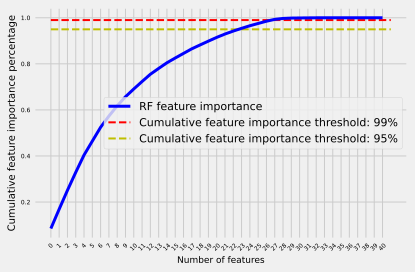

In [35]:
#Plot the cumsum feature importance in terms of chi-values
rf_values = np.sort(rf.feature_importances_)[::-1]

plt.style.use("fivethirtyeight")

rf_cumvalues = np.cumsum(rf_values)/np.sum(rf_values)
n_features = np.arange(len(rf_values))
threshold1 = 0.99
threshold2 = 0.95

plt.plot(n_features, rf_cumvalues, lw=3, color="blue", label="RF feature importance")
plt.hlines(threshold1, xmin=0, xmax=41, linestyle="--", lw=2,
           color="r", label="Cumulative feature importance threshold: 99%")
plt.hlines(threshold2, xmin=0, xmax=41, linestyle="--", lw=2,
           color="y", label="Cumulative feature importance threshold: 95%")

plt.xticks(n_features, fontsize=6, rotation=45)
plt.yticks(fontsize=6)

plt.xlabel("Number of features", fontsize=9)
plt.ylabel("Cumulative feature importance percentage", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.legend(loc="center right", fontsize=11)

In [53]:
# indices_cs=Index_Top_K_Features(chi_val, 22)
# indices_pca=Index_Top_K_Features(pca.explained_variance_ratio_, 24)
indices_rf=Index_Top_K_Features(rf.feature_importances_, 27)
indices_gbm=Index_Top_K_Features(gbm2.feature_importances_, 27)

# print(indices_cs)
# print(indices_pca)
print(indices_rf)
print(indices_gbm)

[7, 14, 15, 9, 13, 12, 6, 4, 16, 8, 3, 33, 5, 10, 11, 0, 1, 39, 24, 19, 2, 18, 40, 25, 28, 17, 27]
[12, 34, 23, 11, 10, 27, 14, 15, 13, 7, 17, 18, 20, 25, 28, 9, 4, 24, 0, 6, 16, 19, 5, 8, 3, 40, 21]


In [45]:
df_rf.columns[indices_rf]

Index(['num_lab_procedures', 'diag_2', 'diag_3', 'num_medications', 'diag_1',
       'number_inpatient', 'time_in_hospital', 'discharge_disposition_id',
       'number_diagnoses', 'num_procedures', 'admission_type_id', 'insulin',
       'admission_source_id', 'number_outpatient', 'number_emergency', 'race',
       'gender', 'change', 'glipizide', 'metformin', 'age', 'A1Cresult',
       'diabetesMed', 'glyburide', 'rosiglitazone', 'max_glu_serum',
       'pioglitazone'],
      dtype='object')

In [39]:
np.sort(np.round(gbm2.feature_importances_, 4))

NameError: name 'gbm2' is not defined

In [40]:
df_rf.columns[:-1][indices_gbm]

NameError: name 'indices_gbm' is not defined

In [41]:
### Standardisation
    #Select the scaling range of the dataset
data_to_scale = df_lstm2.iloc[:,:-3]

scaler = MinMaxScaler()
df_lstm2.iloc[:,:-3] = scaler.fit_transform(data_to_scale)
print(df_lstm2.head())

patient_groups, patient_groups1, patient_groups2, patient_groups3, target_groups = Group_Patients_Time_Step(df_lstm2, [indices_cs, indices_pca, indices_rf])

x_train_lstm, x_test_lstm, y_train_lstm, y_test_lstm = train_test_split(patient_groups, target_groups, \
                                                                            test_size=0.3, random_state=42,\
                                                                           stratify=target_groups, shuffle=True)
x_train_lstm1, x_test_lstm1, y_train_lstm1, y_test_lstm1 = train_test_split(patient_groups1, target_groups, \
                                                                            test_size=0.3, random_state=42,\
                                                                           stratify=target_groups, shuffle=True)
x_train_lstm2, x_test_lstm2, y_train_lstm2, y_test_lstm2 = train_test_split(patient_groups2, target_groups, \
                                                                            test_size=0.3, random_state=42,\
                                                                           stratify=target_groups, shuffle=True)
x_train_lstm3, x_test_lstm3, y_train_lstm3, y_test_lstm3 = train_test_split(patient_groups3, target_groups, \
                                                                            test_size=0.3, random_state=42,\
                                                                           stratify=target_groups, shuffle=True)

len(x_train_lstm1), len(x_test_lstm1)

100%|██████████| 2/2 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

   race  gender       age  admission_type_id  discharge_disposition_id  \
0  0.00     0.0  0.000000           0.714286                  0.888889   
1  0.00     0.0  0.333333           0.000000                  0.000000   
2  0.25     0.0  0.666667           0.000000                  0.000000   
3  0.00     0.5  0.666667           0.000000                  0.000000   
4  0.00     0.5  0.666667           0.000000                  0.000000   

   admission_source_id  time_in_hospital  num_lab_procedures  num_procedures  \
0                 0.00          0.000000            0.305344        0.000000   
1                 0.25          0.153846            0.442748        0.000000   
2                 0.25          0.076923            0.076336        0.833333   
3                 0.25          0.076923            0.328244        0.166667   
4                 0.25          0.000000            0.381679        0.000000   

   num_medications  ...  glyburide-metformin  glipizide-metformin  \
0    



100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 8000.58it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<?, ?it/s]

100%|████████

KeyboardInterrupt: 

In [ ]:
y_train_lstm1 = np.array(y_train_lstm1).astype("int32")
y_test_lstm1 = np.array(y_test_lstm1).astype("int32")

y_train_lstm2 = np.array(y_train_lstm2).astype("int32")
y_test_lstm2 = np.array(y_test_lstm2).astype("int32")

y_train_lstm3 = np.array(y_train_lstm3).astype("int32")
y_test_lstm3 = np.array(y_test_lstm3).astype("int32")

y_train_lstm = np.array(y_train_lstm).astype("int32")
y_test_lstm = np.array(y_test_lstm).astype("int32")

y_train_lstm1.shape, y_test_lstm1.shape

In [ ]:
#No FS
x_train_lstm_tensor = tf.ragged.constant(x_train_lstm)
x_test_lstm_tensor = tf.ragged.constant(x_test_lstm)

# #CS
# x_train_lstm1_tensor = tf.ragged.constant(x_train_lstm1)
# x_test_lstm1_tensor = tf.ragged.constant(x_test_lstm1)

# #PCA
# x_train_lstm2_tensor = tf.ragged.constant(x_train_lstm2)
# x_test_lstm2_tensor = tf.ragged.constant(x_test_lstm2)

#RF
x_train_lstm3_tensor = tf.ragged.constant(x_train_lstm3)
x_test_lstm3_tensor = tf.ragged.constant(x_test_lstm3)


### Save and load

In [ ]:
# np.save("D:/y_train_lstm1.npy",y_train_lstm1)
# np.save("D:/y_test_lstm1.npy",y_test_lstm1)

# np.save("D:/y_train_lstm2.npy",y_train_lstm2)
# np.save("D:/y_test_lstm2.npy",y_test_lstm2)

# np.save("D:/y_train_lstm3.npy",y_train_lstm3)
# np.save("D:/y_test_lstm3.npy",y_test_lstm3)

np.save("D:/x_train_lstm3.npy",x_train_lstm3)
np.save("D:/x_test_lstm3.npy",x_test_lstm3)

np.save("D:/x_train_lstm2.npy",x_train_lstm2)
np.save("D:/x_test_lstm2.npy",x_test_lstm2)

np.save("D:/x_train_lstm1.npy",x_train_lstm1)
np.save("D:/x_test_lstm1.npy",x_test_lstm1)

np.save("D:/x_train_lstm.npy",x_train_lstm)
np.save("D:/x_test_lstm.npy",x_test_lstm)



np.save("D:/y_train_lstm.npy",y_train_lstm)
np.save("D:/y_test_lstm.npy",y_test_lstm)

In [ ]:
#Load the restored datasets
x_train_lstm3 = np.load("D:/x_train_lstm3.npy", allow_pickle=True)
x_test_lstm3 = np.load("D:/x_test_lstm3.npy", allow_pickle=True)

x_train_lstm = np.load("D:/x_train_lstm.npy", allow_pickle=True)
x_test_lstm = np.load("D:/x_test_lstm.npy", allow_pickle=True)

y_train_lstm = np.load("D:/y_train_lstm.npy", allow_pickle=True)
y_test_lstm = np.load("D:/y_test_lstm.npy", allow_pickle=True)

In [ ]:
ma = max(df_lstm2.iloc[:,0])
mi = min(df_lstm2.iloc[:,0])

df_lstm2.iloc[:,0]/ma

In [ ]:
x_train_lstm3[7000]

In [ ]:
x_train_lstm3_tensor.shape, y_train_lstm.shape

#### Develop LSTM model

#### With FS

In [ ]:
#Centre loss
import import_ipynb
import CentreLoss
cl_layer = CentreLoss.Centre_loss(num_classes=2, feature_dim=2)

In [ ]:
input_lstm = Input(shape=[None, 27], ragged=True)

x1 = LSTM(50, activation="tanh", use_bias=True, unroll=False, return_sequences=False, )(input_lstm)

x2 = LSTM(50, activation="tanh", use_bias=True, unroll=False, return_sequences=True)(input_lstm)
x2 = LSTM(50, activation="tanh", use_bias=True, unroll=False)(x2)

x = layers.concatenate([x1, x2])

x = Dense(80, kernel_regularizer=keras.regularizers.l2(5e-3))(x)
x = BatchNormalization()(x)
x = layers.LeakyReLU(0.3)(x)
x = Dropout(0.2)(x)

x = Dense(64, kernel_regularizer=keras.regularizers.l2(5e-3))(x)
x = BatchNormalization()(x)
x = layers.LeakyReLU(0.3)(x)
x = Dropout(0.2)(x)

x = Dense(32, kernel_regularizer=keras.regularizers.l2(5e-3))(x)
x = BatchNormalization()(x)
x = layers.LeakyReLU(0.3)(x)
x = Dropout(0.2)(x)

x = Dense(16, kernel_regularizer=keras.regularizers.l2(5e-3))(x)
x = BatchNormalization()(x)
x = layers.LeakyReLU(0.3)(x)
x = Dropout(0.2)(x)

x = Dense(8, kernel_regularizer=keras.regularizers.l2(5e-3))(x)
x = BatchNormalization()(x)
x = layers.LeakyReLU(0.3)(x)
x = Dropout(0.2)(x)

x = Dense(4, kernel_regularizer=keras.regularizers.l2(5e-3))(x)
x = BatchNormalization()(x)
x = layers.LeakyReLU(0.3)(x)
x = Dropout(0.2)(x)

output_lstm = Dense(2)(x)

lstm = Model(inputs=input_lstm, outputs=output_lstm)


In [ ]:
db_train = tf.data.Dataset.from_tensor_slices((x_train_lstm3_tensor, tf.one_hot(y_train_lstm, depth=2))).shuffle(1000).batch(128).prefetch(1)
db_test = tf.data.Dataset.from_tensor_slices((x_test_lstm3_tensor, tf.one_hot(y_test_lstm, depth=2))).batch(128).prefetch(1)

next(iter(db_train))[0].shape, next(iter(db_train))[1].shape

#### Custom training

In [ ]:
import import_ipynb
import CentreLoss

cl_layer = CentreLoss.Centre_loss(num_classes=2, feature_dim=2)

In [ ]:
# optimiser = keras.optimizers.Adam(1e-3)
# loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)
# accuracy = keras.metrics.BinaryAccuracy()

# for epoch in range(1000):
#     for step, (x_train, y_train) in enumerate(db_train):
#         with tf.GradientTape() as tape:
#             logits1 = lstm(x_train)
#             loss1 = loss_fn(y_train, logits1)
            
#             cl_loss = cl_layer(logits1, tf.argmax(y_train, axis=1))
#             loss_train = loss1 + cl_loss
            
#             probs1 = tf.nn.softmax(logits1, axis=1)
#             labels1 = tf.argmax(probs1, axis=1)
#             labels1 = tf.cast(labels1, dtype=tf.int32)
#             accuracy.update_state(y_train, probs1)
            
#         grads = tape.gradient(loss_train, lstm.trainable_variables)
#         optimiser.apply_gradients(zip(grads, lstm.trainable_variables))
        
#         if step%200==0:
#             print("Epoch {}, step {}, loss: {}, acc: {}".format(epoch, step, loss_train, accuracy.result()))
        
#         accuracy.reset_states()
        
#     y_preds=[]
#     y_truths=[]
#     for x_test, y_test in db_test:
#         probs2 = lstm(x_test)
#         labels = tf.argmax(probs2, axis=1)
#         labels = tf.cast(labels, dtype=tf.int32)
        
#         y_preds+=list(labels)
#         y_truths+=(list(tf.argmax(y_test, axis=1)))
    
#     auc, recall, acc, specificity = Evaluation_Metrics(y_truths, y_preds)
#     print("-------auc: {}, recall: {}\n-------accuracy: {}, specificity: {}".format(auc, recall, acc, specificity))
        

In [ ]:
keras.utils.plot_model(lstm, "D:/2-1-lstm.png", show_shapes=True)

## Normal training

In [ ]:
np.unique(y_train_lstm, return_counts=True)

In [ ]:
optimiser=optimizers.Adam(1e-4)
# optimiser=optimizers.SGD(1e-5, momentum=0.3, nesterov=True)
loss_fn = losses.BinaryCrossentropy(from_logits=True)

lstm.compile(optimizer=optimiser, metrics=["acc"], loss=loss_fn)

#onehot
y_train_onehot = tf.one_hot(y_train_lstm, depth=2)

metric = Metrics(model=lstm, x_valid=x_test_lstm3_tensor, y_valid=y_test_lstm,\
                path="D:/Python/Tensorflow/Logs/Readmission/LSTM/")

weights={0:1, 1:8}
lstm.fit(x_train_lstm3_tensor, y_train_onehot, epochs=1000, initial_epoch=0, batch_size=128, \
         class_weight=weights,\
        callbacks=[metric, tb_callback2],\
        workers=-1, use_multiprocessing=True)


## Custom training

### Combined classifier from GBM and LSTM

##### combine by condictional probability ---- precision

In [ ]:
#Prepare the train and test sets for GBM
x_train_gbm = []
x_test_gbm = []

for ob_train in x_train_lstm3:
    #the test sample for GBM is the last sample/ time step in each observation of the x_test_lstm
    ob_gbm_train = ob_train[-1]
    x_train_gbm.append(ob_gbm_train)

for ob_test in x_test_lstm3:
    #the test sample for GBM is the last sample/ time step in each observation of the x_test_lstm
    ob_gbm_test = ob_test[-1]
    x_test_gbm.append(ob_gbm_test)
    
x_train_gbm=np.array(x_train_gbm)
x_test_gbm=np.array(x_test_gbm)

In [ ]:
#Train the GBM with the training set
gbm_com=XGBClassifier(n_estimators=2500, max_depth=6, learning_rate=0.3, subsample=0.1,\
                                        eval_metric = "logloss", tree_method="gpu_hist", gpu_id=0, n_jobs =-1, use_label_encoder=False)
gbm_com.fit(x_train_gbm, y_train_lstm)
predictions_gbm = gbm_com.predict(x_test_gbm)

auc2_gbm, recall2_gbm, acc2_gbm, specificity2_gbm = Evaluation_Metrics(y_test_lstm, predictions_gbm)

# auc1_gbm, auc2_gbm, recall1_gbm, recall2_gbm, acc1_gbm, acc2_gbm, specificity1_gbm, specificity2_gbm
auc2_gbm, recall2_gbm, acc2_gbm, specificity2_gbm

In [ ]:
# Get precision of the two classes in the GBM and LSTM model
from sklearn.metrics import classification_report as Report

#Get the precision of GBM from its report
report_gbm = Report(y_test_lstm, predictions_gbm, output_dict=True)

precisions_gbm = {
    "0":report_gbm["0"]["precision"],
    "1":report_gbm["1"]["precision"]
}

#Get the precision of LSTM from its report
report_lstm = Report(y_test_lstm, tf.argmax(tf.nn.softmax(lstm(x_test_lstm3_tensor), axis=1), axis=1), output_dict=True)

precisions_lstm = {
    "0":report_gbm["0"]["precision"],
    "1":report_gbm["1"]["precision"]
}

In [ ]:
# Get the probability of the predicted classes in each model
prob_gbm = gbm_com.predict_proba(x_test_gbm)

prob_lstm = tf.nn.softmax(lstm(x_test_lstm3_tensor)).numpy()

In [ ]:
#Build up the conditional-probability-classifier
def Clf_GBM_Lstm(i):
    samples = []
    classes = []
    proba_GBM = []
    proba_LSTM = []
    
    samples.append(i)
    samples.append(i)
    
    classes.append(0)
    classes.append(1)
    
    proba_GBM.append(prob_gbm[i][0])
    proba_GBM.append(prob_gbm[i][1])
    proba_LSTM.append(prob_gbm[i][0])
    proba_LSTM.append(prob_gbm[i][1])
    
    proba_table_condition = pd.DataFrame({
        "Sample":samples,
        "Classes":classes,
        "Proba_GBM":proba_GBM,
        "Proba_LSTM":proba_LSTM
    })
    
#     for a in range(2):
#         if proba_table_condition.iloc[a, 2] == proba_table_condition.max()[2]:
#             max_class_GBM=a
#     for b in range(2):
#         if proba_table_condition.iloc[b, 2] == proba_table_condition.max()[3]:
#             max_class_lstm=b
    

#     p1 = proba_table_condition.max()[2] * precisions_gbm[str(max_class_GBM)]
#     p2 = proba_table_condition.max()[3] * precisions_lstm[str(max_class_lstm)]

    p1 = 0.3*(proba_table_condition.iloc[0, 2]*precisions_gbm[str(0)]) + 0.8*(proba_table_condition.iloc[0, 3]*precisions_lstm[str(0)])
    p2 = 0.7*(proba_table_condition.iloc[1, 2]*precisions_gbm[str(1)]) + 0.2*(proba_table_condition.iloc[1, 3]*precisions_lstm[str(1)])
    
    if p1 > p2:
        return 0
    else:
        return 1

In [ ]:
predicitons_com = []

for i in range(len(x_test_gbm)):
    label = Clf_GBM_Lstm(i)
    predicitons_com.append(label)

predicitons_com

In [ ]:
Evaluation_Metrics(y_test_lstm, predicitons_com)